In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from ehtools.configure import *
from ehtools.diatipico import calculate_dt
import numpy as np
from ehtools.calculations import *

In [2]:
materiales = get_list_materials("materiales.ini")
propiedades = read_materials("materiales.ini")
eh = read_configuration("eh.ini")


In [9]:
propiedades["adobe"].c

1480.0

In [14]:
eh.Nx

200

In [15]:
# Lista de tuplas con los valores de L y el material
sc = [
    (0.001,"acero"),
    # (0.1, "adobe")
#     (0.02, "tabique"),
#     (0.1, "concreto"),
]

# Actualizar el diccionario
cs = set_construction(propiedades,sc)
Ltotal  = get_total_L(cs)
Ltotal

0.101

In [23]:
cs["L1"]["material"].rho

25000.0

In [4]:
type(eh.dt)

int

In [24]:
k, rhoc, dx = set_k_rhoc(cs, eh.Nx)

In [28]:
dx

0.000505

In [29]:
f = "../data/dia.parquet"
dia = pd.read_parquet(f)
dia = calculate_dt(dia)

In [30]:
dia

,zenith,elevation,azimuth,equation_of_time,Ta,Ig,Ib,Id,Tn,Is,Tsa,DeltaTn,dt
2024-02-15 00:00:00-06:00,166.292835,-76.292835,294.129023,-14.123533,19.599009,0.0,0.0,0.0,25.012273,0.0,19.599009,1.5,1.0
2024-02-15 00:00:01-06:00,166.296431,-76.296431,294.136995,-14.123532,19.598670,0.0,0.0,0.0,25.012273,0.0,19.598670,1.5,1.0
2024-02-15 00:00:02-06:00,166.300028,-76.300028,294.144970,-14.123532,19.598332,0.0,0.0,0.0,25.012273,0.0,19.598332,1.5,1.0
2024-02-15 00:00:03-06:00,166.303624,-76.303624,294.152950,-14.123531,19.597993,0.0,0.0,0.0,25.012273,0.0,19.597993,1.5,1.0
2024-02-15 00:00:04-06:00,166.307220,-76.307220,294.160933,-14.123531,19.597655,0.0,0.0,0.0,25.012273,0.0,19.597655,1.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-15 23:58:56-06:00,165.911970,-75.911970,294.904119,-14.076002,19.620684,0.0,0.0,0.0,25.012273,0.0,19.620684,1.5,1.0
2024-02-15 23:58:57-06:00,165.915545,-75.915545,294.912098,-14.076002,19.620345,0.0,0.0,0.0,25.012273,0.0,19.620345,1.5,1.0
2024-02-15 23:58:58-06:00,165.919119,-75.919119,294.920081,-14.076001,19.620007,0.0,0.0,0.0,25.012273,0.0,19.620007,1.5,1.0
2024-02-15 23:58:59-06:00,165.922693,-75.922693,294.928067,-14.076001,19.619668,0.0,0.0,0.0,25.012273,0.0,19.619668,1.5,1.0


In [35]:
T = np.full(eh.Nx, dia.Tn.mean())
dia['Ti'] = dia.Tn.mean()
dt  = eh.dt
nx = eh.Nx 
ho = eh.ho
hi = eh.hi
La = eh.La

dia = dia.iloc[::dt]

In [36]:
C = 1
while C > 5e-4: 
    Told = T.copy()
    for tiempo, datos in dia.iterrows():
        a,b,c,d = calculate_coefficients(dt, dx, k, nx, rhoc, T, datos["Tsa"], ho, datos["Ti"], hi)
        T, Ti = solve_PQ(a, b, c, d, T, nx, datos['Ti'], hi, La, dt)
        dia.loc[tiempo,"Ti"] = Ti
    Tnew = T.copy()
    C = abs(Told - Tnew).mean()
    FD   = (dia.Ti.max() - dia.Ti.min())/(dia.Ta.max()-dia.Ta.min())
    FDsa = (dia.Ti.max() - dia.Ti.min())/(dia.Tsa.max()-dia.Tsa.min())
    print(FD,FDsa,C)

0.06811763560804608 0.033372491822724254 0.7140386368180092
0.1298245178083946 0.06360419912223148 0.10744554352023133
0.18570216547312285 0.09098002218359362 0.09867003252149877
0.23626967633217139 0.11575427965121161 0.09041787473345504
0.28199943762420737 0.13815840556002895 0.08265850112690921
0.323327000785741 0.158405787186682 0.07538595900703828
0.36064486611843627 0.1766887200063554 0.06859037647298459
0.39431728954185985 0.19318566188225306 0.06225870641220617
0.4246734512659576 0.20805788623155336 0.05637541614412866
0.45201376961400885 0.22145257532133794 0.05092308184784196
0.47661490041811533 0.23350526959443213 0.045882898261231035
0.49872798973370663 0.24433901163160543 0.041235113257620776
0.5185840855467988 0.25406699747900874 0.03695939599558457
0.5363917807166945 0.2627914218682885 0.03303514650459345
0.5523430237214845 0.270606325042596 0.029441753791949896
0.5666119647205108 0.2775970274144307 0.026158808846287514
0.5793574140952044 0.28384133406478756 0.0231662782

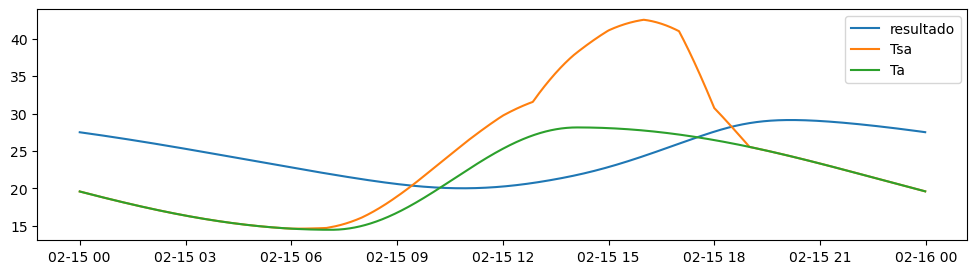

In [37]:
fig, ax = plt.subplots(figsize=(12,3))

ax.plot(dia.Ti,label="resultado")
ax.plot(dia.Tsa,label="Tsa")
ax.plot(dia.Ta,label="Ta")

ax.legend()